
# Hair segmentation - Project for Image processing class

Authors:
* *Aleksandra Duda*
* *Bartosz Belski*
* *Piotr Gucwa*


## Brief

The goal of this project was to train an AI model for image segmenation (Hair segmentation). By hair segmentation we mean to find a mask of hair from the input image. Hair of mask is just a map of zeros and ones where ones are pixels that are part of hair. Later we can use it for various tasks like hair coloring or applying some fancy filters. We chose to show example with hair coloring. 

## Tech Stack
* Tensorflow (https://www.tensorflow.org/)
* Numpy (https://numpy.org/doc/stable/index.html)
* Matplotlib (https://matplotlib.org/stable/index.html)
* OpenCV (https://opencv.org/)
* Pillow (https://pillow.readthedocs.io/en/stable/index.html)

## Hair segmentation 

### Imports

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

### Mount google drive 

In [2]:
import sys
from google.colab import drive
drive.mount('/content/drive')
path_nb = r'/content/drive/My Drive/Colab Notebooks/'
sys.path.append(path_nb)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Dataset

Source: https://github.com/switchablenorms/CelebAMask-HQ

Paper: https://arxiv.org/pdf/1907.11922.pdf

We decided to use dataset called CelebAMask-HQ which consist of over 30,000 face images of
512×512 resolution, where each image is annotated with
a semantic mask of 19 facial component categories, e.g. eye
region, nose region, mouth region, **hair region**.

### Load dataset

We extracted 2000 images with 2000 hair masks in 128x128 resolution and 3 channels (images with colors). The limitations comes from limited memory (Google colab has 12GB limitation on RAM). We also agreed that number of images we limited and scale ratio are fair mutually. Also we agreed on statement that colors plays an important role in hair segmentation problem.

We decided to use `.npy` files because of how fast it is loading numpy arrays and we wanted to avoid loading every file separately.

In [3]:
dataset = np.load(f'{path_nb}dataX2000x128x128x3.npy', allow_pickle=True)

### Preprocessing and normalization

For our training process we need to normalize data. We normalize typical RGB integer values of pixels `[0:255]` to `[0:1]` float values. We also set precision of float data to `float32` dtype from numpy package.

In [4]:
dataset = np.resize(dataset, (len(dataset), 2, 128, 128, 3))
masks = dataset[:,0]/255
images = dataset[:,1]/255
masks = np.asarray(masks).astype('float32')
images = np.asarray(images).astype('float32')

Because masks were also loaded as RGB images, all of them had 3 channels, while it is only storing black and white values. So we resized every mask from 3 channels to 1. It can be done by `np.resize()`.

In [5]:
# Resize mask to graysacle
R = masks[:, :, :, 0]
R = np.resize(R, (1744, 128, 128, 1))
masks = R

### Create a Tensorflow dataset

In [6]:
ds = tf.data.Dataset.from_tensor_slices((images, masks))

After creating Tensorflow dataset we need to split this dataset into train, validation and test dataset. We have used 8/1/1 ratio.

In [7]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_images, _, test_images = get_dataset_partitions_tf(ds, len(ds))

### Data augmentation

Because we loaded only 2000 of images we created a data augmentation generator. The following class performs a simple augmentation by randomly-flipping an image. It is better than loading an extra images from dataset, because here we have a function that will ad-hoc create extra images, so it will not occupy extra memory.

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

### Setup train constants


In [9]:
TRAIN_LENGTH = len(train_images)
BATCH_SIZE = 64
BUFFER_SIZE = 1000

Build the input pipeline, applying the Augmentation after batching the inputs.

In [10]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset.

In [11]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

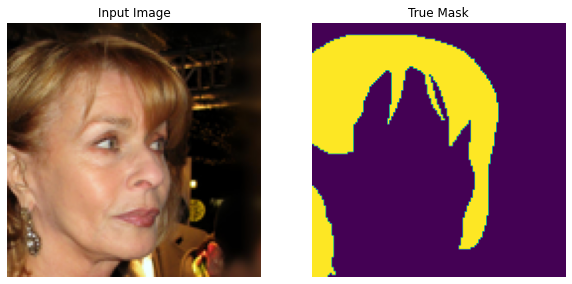

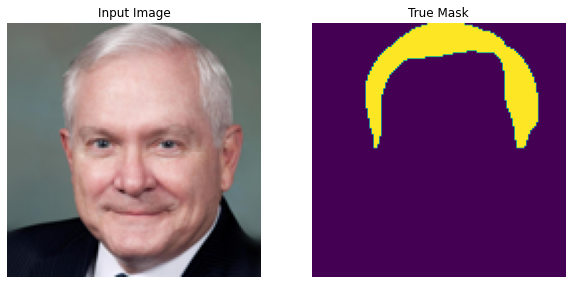

In [12]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

### Define the model
The model we used here is a modified U-net architecture. A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to reduce the number of trainable parameters, we will use a pretrained model - MobileNetV2 (https://keras.io/api/applications/mobilenet/) - as the encoder. For the decoder, we will use the upsample block, which is already implemented in the pix2pix(https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo.

Pix2pix paper is under that link: https://phillipi.github.io/pix2pix/


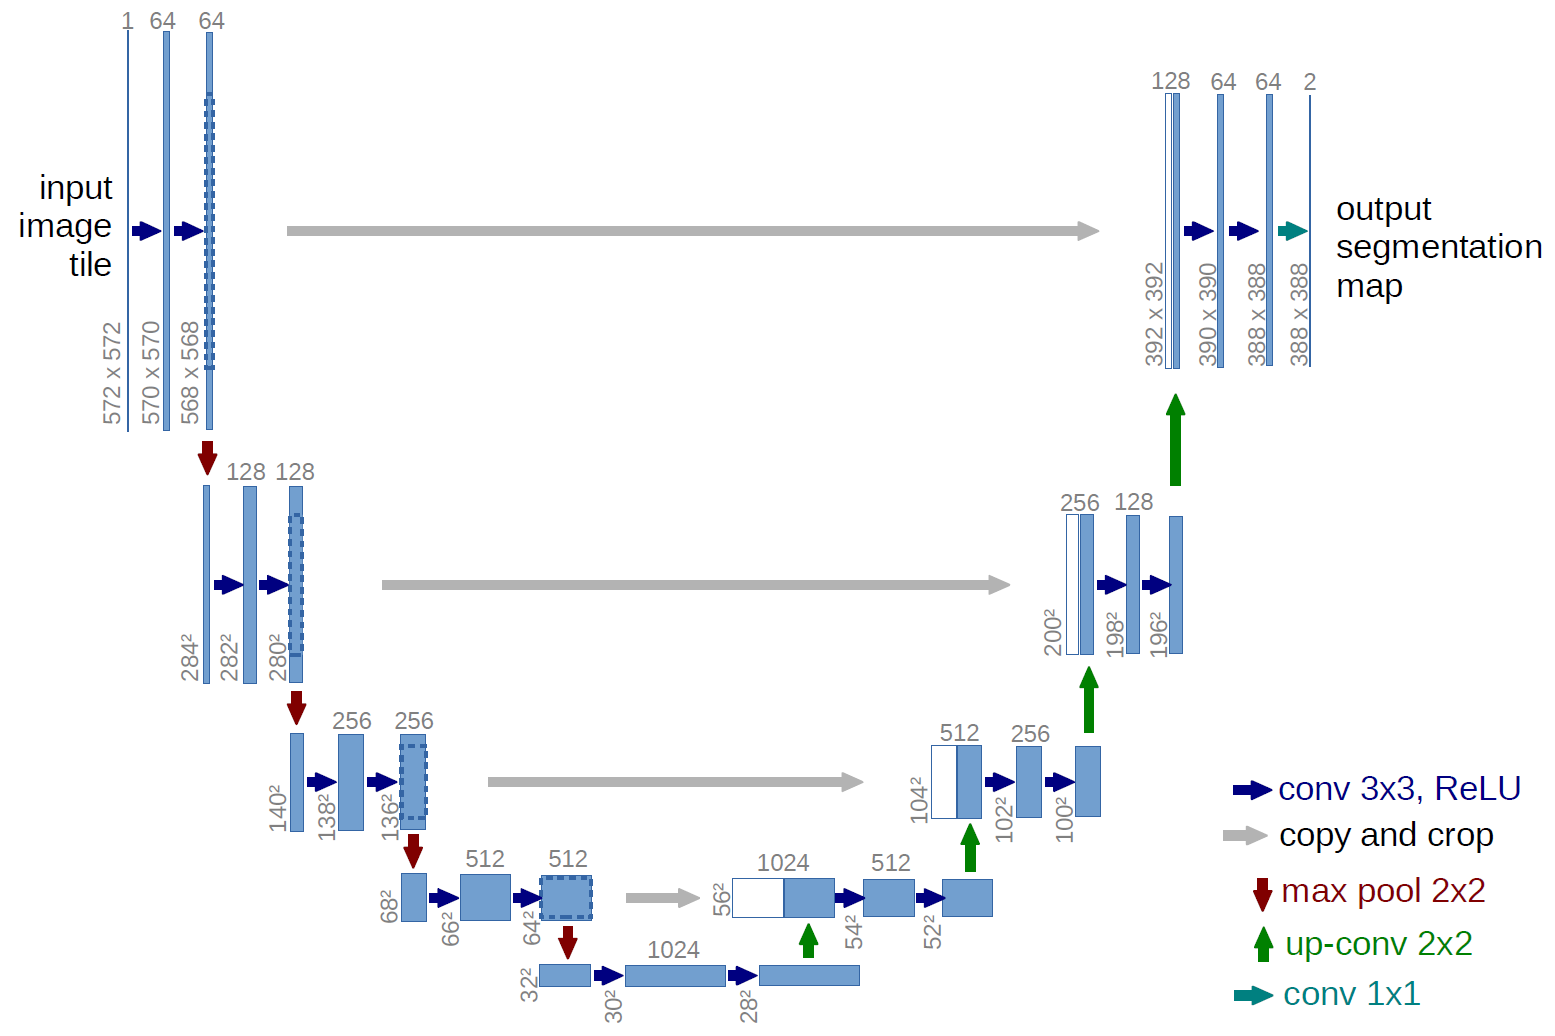

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Encoder will stay "freeze" so it will not be trained.

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

### pix2pix installation

In [14]:
!pip install -q git+https://github.com/tensorflow/examples.git

The decoder/upsampler is simply a series of upsample blocks implemented from TensorFlow examples.

In [15]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

### Compile the model

Since this is a multiclass classification problem, we used the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. We set `OUTPUT_CLASSES` to 2, because masks have only two values 1 or 0. We also tried different optimizers, but `Adam` optimizer had the best results.


In [17]:
OUTPUT_CLASSES = 2

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model visualisation

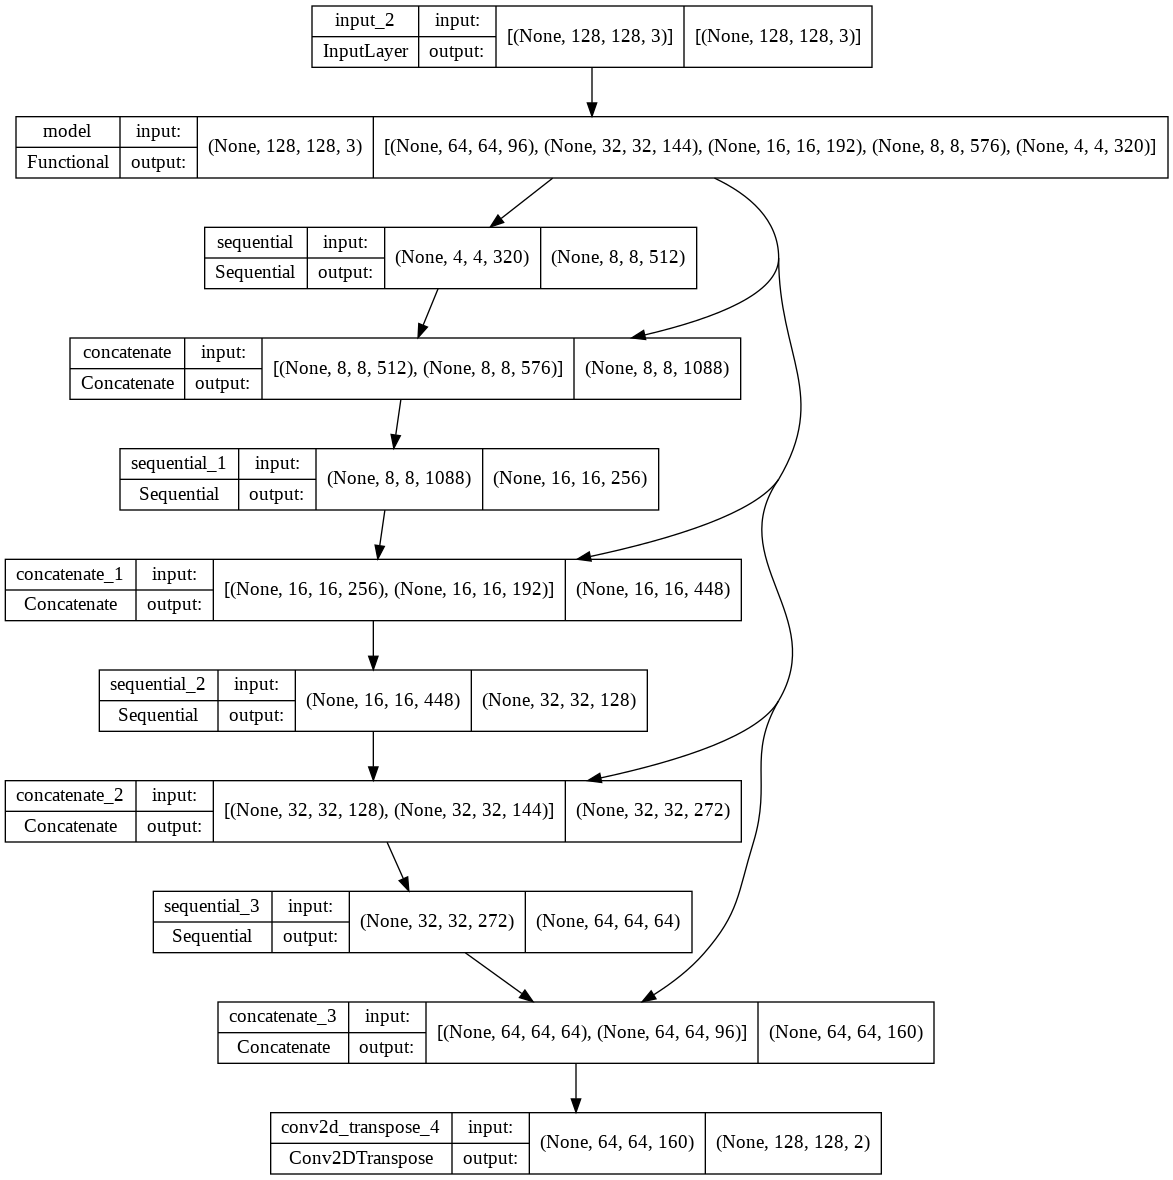

In [18]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Model predictions before training

First we wanted to check how model performs on images from dataset on pretrained model.

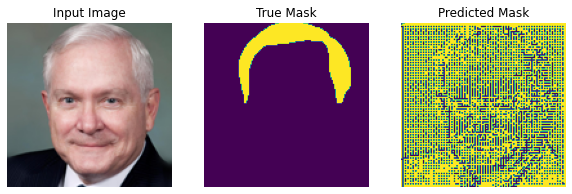

In [19]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
  
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])
    
show_predictions()

Results confirm us that the model not yet know anything about "hair". MobileNetV2 from keras was trained on `imagenet` dataset which does not contain any data to perform hair segmentation. As a result we get prediction that we can't see any pattern.

### Training

The callback defined below is used to observe how the model improves while it is training.

In [20]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    # clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [21]:
import math

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / BATCH_SIZE))

STEPS_PER_EPOCH = compute_steps_per_epoch(len(train_images))
VALIDATION_STEPS = compute_steps_per_epoch(len(test_images))

Epoch 1/20
22/22 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.7828

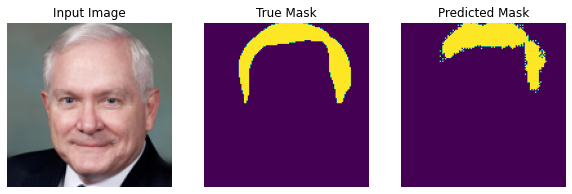


Sample Prediction after epoch 1

22/22 [==============================] - 14s 292ms/step - loss: 0.4777 - accuracy: 0.7828 - val_loss: 0.2210 - val_accuracy: 0.9127
Epoch 2/20
22/22 [==============================] - ETA: 0s - loss: 0.2014 - accuracy: 0.9251

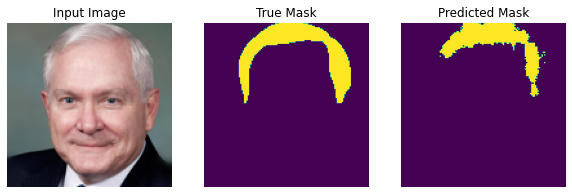


Sample Prediction after epoch 2

22/22 [==============================] - 4s 163ms/step - loss: 0.2014 - accuracy: 0.9251 - val_loss: 0.2065 - val_accuracy: 0.9183
Epoch 3/20
22/22 [==============================] - ETA: 0s - loss: 0.1637 - accuracy: 0.9348

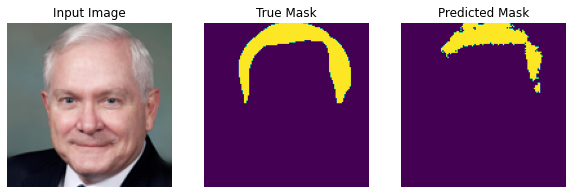


Sample Prediction after epoch 3

22/22 [==============================] - 4s 162ms/step - loss: 0.1637 - accuracy: 0.9348 - val_loss: 0.1765 - val_accuracy: 0.9279
Epoch 4/20
22/22 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9416

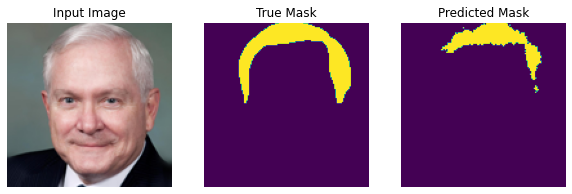


Sample Prediction after epoch 4

22/22 [==============================] - 4s 163ms/step - loss: 0.1460 - accuracy: 0.9416 - val_loss: 0.2255 - val_accuracy: 0.9062
Epoch 5/20
22/22 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9453

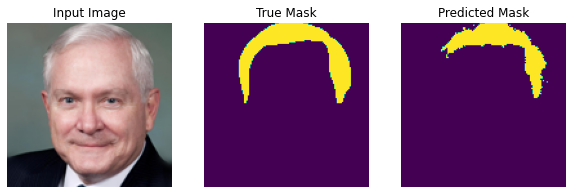


Sample Prediction after epoch 5

22/22 [==============================] - 4s 173ms/step - loss: 0.1360 - accuracy: 0.9453 - val_loss: 0.1910 - val_accuracy: 0.9197
Epoch 6/20
22/22 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9477

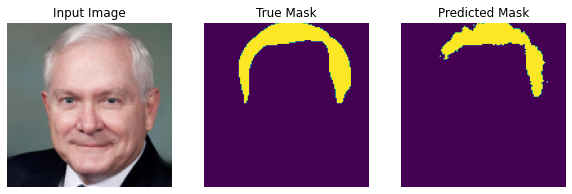


Sample Prediction after epoch 6

22/22 [==============================] - 4s 164ms/step - loss: 0.1296 - accuracy: 0.9477 - val_loss: 0.1654 - val_accuracy: 0.9318
Epoch 7/20
22/22 [==============================] - ETA: 0s - loss: 0.1224 - accuracy: 0.9507

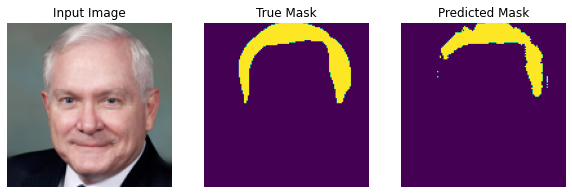


Sample Prediction after epoch 7

22/22 [==============================] - 4s 169ms/step - loss: 0.1224 - accuracy: 0.9507 - val_loss: 0.1537 - val_accuracy: 0.9380
Epoch 8/20
22/22 [==============================] - ETA: 0s - loss: 0.1181 - accuracy: 0.9523

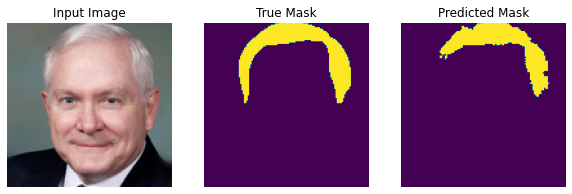


Sample Prediction after epoch 8

22/22 [==============================] - 4s 165ms/step - loss: 0.1181 - accuracy: 0.9523 - val_loss: 0.1393 - val_accuracy: 0.9431
Epoch 9/20
22/22 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9538

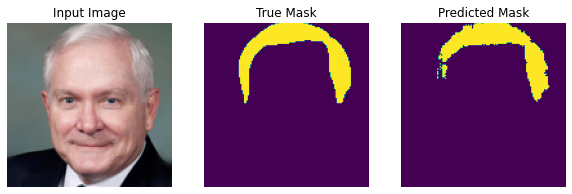


Sample Prediction after epoch 9

22/22 [==============================] - 4s 165ms/step - loss: 0.1140 - accuracy: 0.9538 - val_loss: 0.1156 - val_accuracy: 0.9551
Epoch 10/20
22/22 [==============================] - ETA: 0s - loss: 0.1099 - accuracy: 0.9557

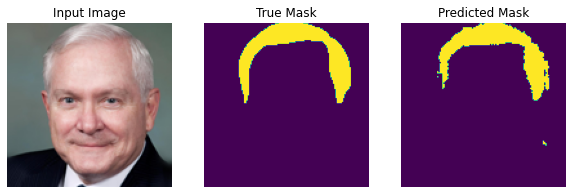


Sample Prediction after epoch 10

22/22 [==============================] - 4s 203ms/step - loss: 0.1099 - accuracy: 0.9557 - val_loss: 0.1084 - val_accuracy: 0.9577
Epoch 11/20
22/22 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9568

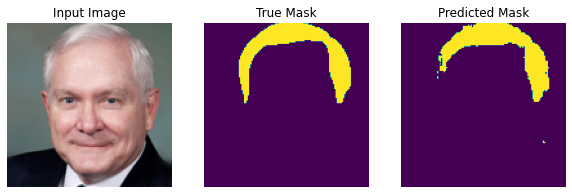


Sample Prediction after epoch 11

22/22 [==============================] - 5s 224ms/step - loss: 0.1065 - accuracy: 0.9568 - val_loss: 0.1169 - val_accuracy: 0.9538
Epoch 12/20
22/22 [==============================] - ETA: 0s - loss: 0.1056 - accuracy: 0.9571

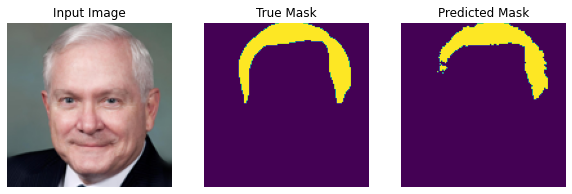


Sample Prediction after epoch 12

22/22 [==============================] - 4s 168ms/step - loss: 0.1056 - accuracy: 0.9571 - val_loss: 0.1106 - val_accuracy: 0.9560
Epoch 13/20
22/22 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9585

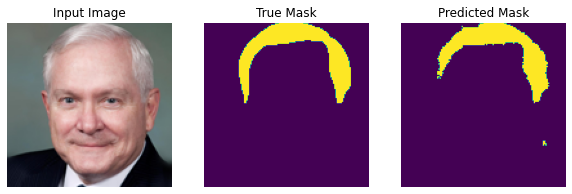


Sample Prediction after epoch 13

22/22 [==============================] - 4s 166ms/step - loss: 0.1020 - accuracy: 0.9585 - val_loss: 0.1081 - val_accuracy: 0.9565
Epoch 14/20
22/22 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.9600

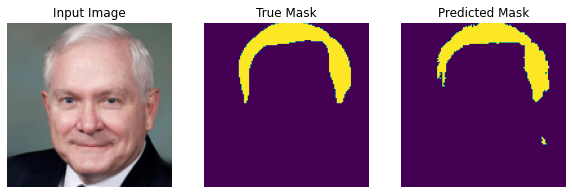


Sample Prediction after epoch 14

22/22 [==============================] - 4s 185ms/step - loss: 0.0986 - accuracy: 0.9600 - val_loss: 0.0997 - val_accuracy: 0.9608
Epoch 15/20
22/22 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9608

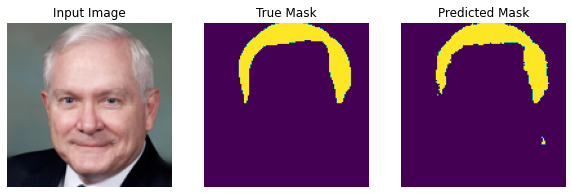


Sample Prediction after epoch 15

22/22 [==============================] - 4s 175ms/step - loss: 0.0965 - accuracy: 0.9608 - val_loss: 0.1013 - val_accuracy: 0.9599
Epoch 16/20
22/22 [==============================] - ETA: 0s - loss: 0.0942 - accuracy: 0.9616

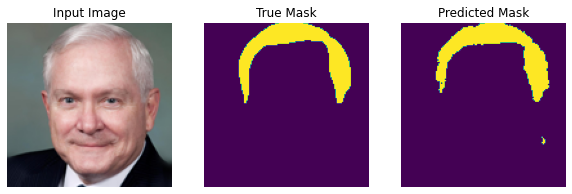


Sample Prediction after epoch 16

22/22 [==============================] - 4s 168ms/step - loss: 0.0942 - accuracy: 0.9616 - val_loss: 0.0983 - val_accuracy: 0.9614
Epoch 17/20
22/22 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9632

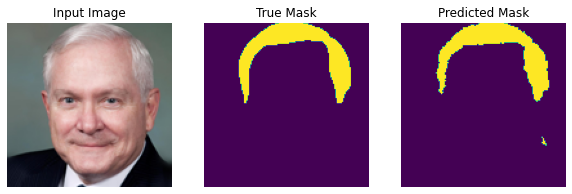


Sample Prediction after epoch 17

22/22 [==============================] - 4s 167ms/step - loss: 0.0906 - accuracy: 0.9632 - val_loss: 0.1085 - val_accuracy: 0.9577
Epoch 18/20
22/22 [==============================] - ETA: 0s - loss: 0.0939 - accuracy: 0.9618

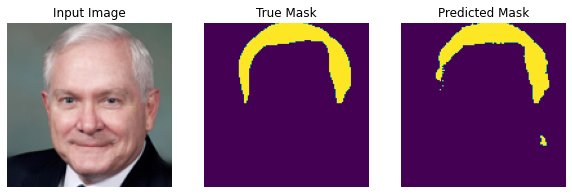


Sample Prediction after epoch 18

22/22 [==============================] - 4s 167ms/step - loss: 0.0939 - accuracy: 0.9618 - val_loss: 0.0976 - val_accuracy: 0.9615
Epoch 19/20
22/22 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9614

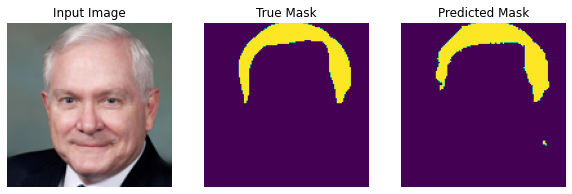


Sample Prediction after epoch 19

22/22 [==============================] - 4s 165ms/step - loss: 0.0945 - accuracy: 0.9614 - val_loss: 0.0938 - val_accuracy: 0.9628
Epoch 20/20
22/22 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9643

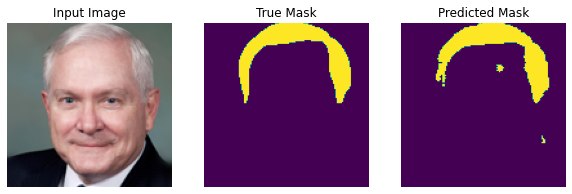


Sample Prediction after epoch 20

22/22 [==============================] - 4s 167ms/step - loss: 0.0880 - accuracy: 0.9643 - val_loss: 0.0917 - val_accuracy: 0.9632


In [22]:
EPOCHS = 20

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

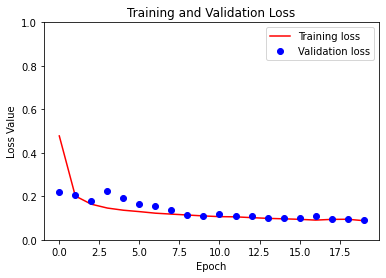

In [23]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Our callback function shows how predicted mask is changing after each epoch one single example. We have run few iterations of our training process and always we get >95% of accuracy. 

Because of how high accuracy we got, we left number of epoch as 20. On the plot we see that training process going towards over-fitting.

### Model predictions after training

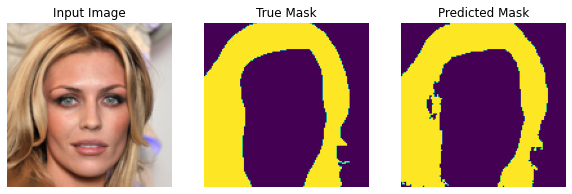

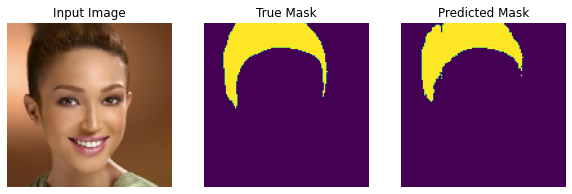

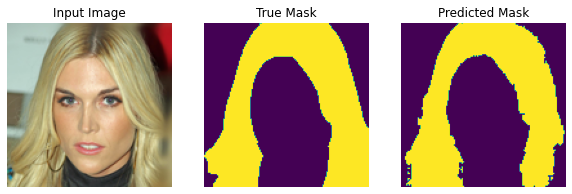

In [24]:
show_predictions(test_batches, 3)

These results are much better than it was in previous chapter and predictions are almost equal to given mask. The biggest problem is in the shape of predicted mask, hair their looks jagged and increasing number of iterations couldn't help. 

We were thinking about inserting here some morphologic operations to make edges of mask smoother as it was described here:

https://stackoverflow.com/questions/53877035/how-can-i-smooth-the-segmented-blob

Sadly we haven't found a time for testing it.

## Hair coloring

Now we have an accurate model for hair segmentation, we could use a predicted mask for hair coloring. Basicly hair coloring is done by applying a defined color to white pixels from predicted mask. 

We specified few colors to work with:

In [25]:
BROWN_HC = [170,136,102]
BLONDE_HC = [222,190,153]
DARK_BLONDE_HC = [36,28,17]
DARK_BROWN_HC = [79,26,0]
DARK_GINGER_HC = [154,51,0]

RED = [255, 0, 0]
BLUE = [0, 255, 0]
GREEN = [0, 0, 255]

RGB_COLORS = [BLUE, GREEN, RED]

COLOR_INPUT = BROWN_HC

### Aplying color to image

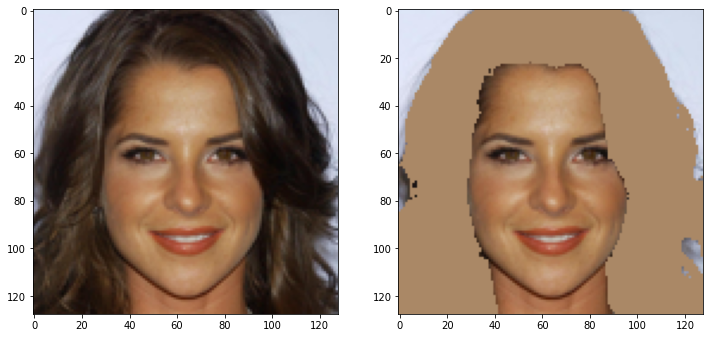

In [26]:
import cv2

def tensor_to_image(tensor):
    image = tensor[0].numpy() * 255
    image = np.asarray(image).astype('uint8')
    return image

for image, _ in test_batches.take(1):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    pred_mask = np.asarray(pred_mask).astype('uint8')
    pred_mask = pred_mask * 255
    image = tensor_to_image(image)
    _, pred_mask = cv2.threshold(pred_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
    # unique, counts = np.unique(pred_mask, return_counts=True)
    # print(dict(zip(unique, counts)))
    image_segmented = np.copy(image)
    image_segmented[(pred_mask==255)] = COLOR_INPUT
    fig, ax = plt.subplots(1,2,figsize=(12,6))
    ax[0].imshow(image)
    ax[1].imshow(image_segmented)

We can see that applying color just like that will not be accurate. Our proposition for improving that will be add weights to the photo that will mix colors of real hair color and color we want to dye hair.

### Applying color to image with weights (blending)

Blended image will be caluclated by OpenCV function called `addWeighted()`, which is implementation of this function:

`g(x)=(1−α)f0(x)+αf1(x)`

For us `f0(x)` and `f1(x)` are our image and image with inserted mask. By modifying `α` parameter we can choose how significant are the colors of pixels in `f1(x)` image. 

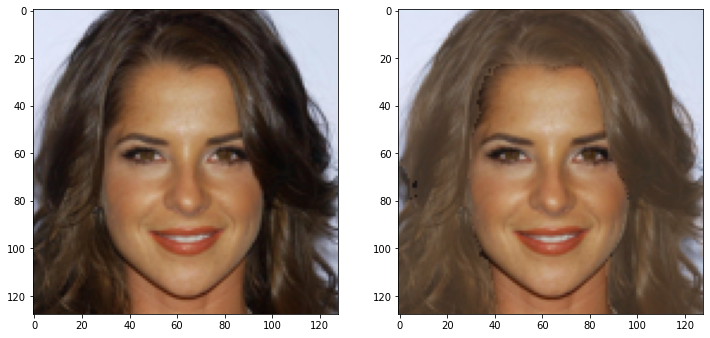

In [27]:
image_segmented_weighted = cv2.addWeighted(image_segmented, 0.3, image, 0.7, 0, image_segmented)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(image)
ax[1].imshow(image_segmented_weighted)

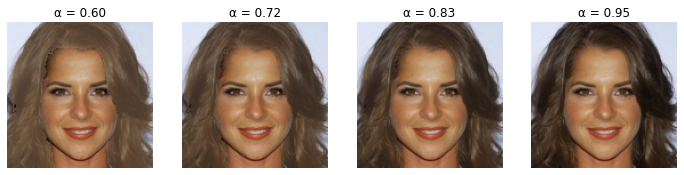

In [28]:
image_segmented = np.copy(image)
image_segmented[(pred_mask==255)] = COLOR_INPUT
fig, axes = plt.subplots(1, 4, figsize=(12,12))
for ax, alpha in zip(axes.flatten(), np.linspace(.6, .95, 4)):
    image_segmented_weighted = cv2.addWeighted(image_segmented, 1-alpha, image, alpha, 0, image_segmented_weighted)
    ax.imshow(image_segmented_weighted)
    ax.set_title(f'α = {alpha:.2f}')
    ax.axis('off')

### Outside dataset tests

We want to perform our final tests on our own photos to test how it will perform in in-wild photos. Model was trained on cropped images, so we also manually cropped our faces from images.

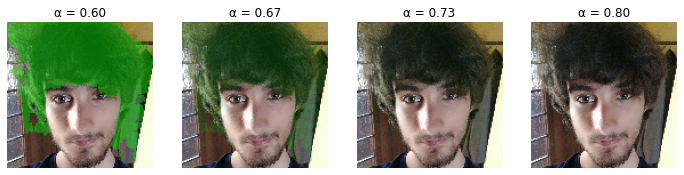

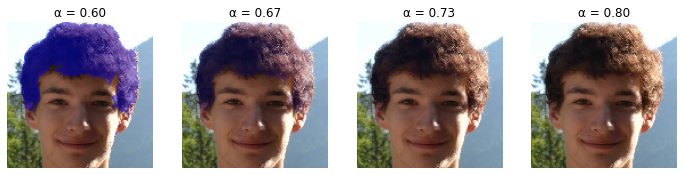

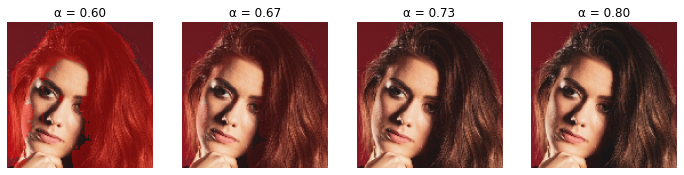

In [29]:
from PIL import Image

def load_image(infilename) :
    img = Image.open(infilename).convert('RGB')
    img = img.resize((128, 128), Image.NEAREST)
    data = np.asarray(img, dtype="float32")
    data = data/255.0
    if data.shape[2] == 4:
        data = np.resize(data, (data.shape[0], data.shape[1], 3))
    return data

def test_image_outside_dataset(filename: str):
    images_data = [load_image(filename)]
    ds = tf.data.Dataset.from_tensor_slices((images_data))
    ds = ds.batch(BATCH_SIZE)

    fig, axes = plt.subplots(1, 4, figsize=(12,12))
    for image in ds.take(1):
        pred_mask = model.predict(image)
        pred_mask = create_mask(pred_mask)
        pred_mask = np.asarray(pred_mask).astype('uint8')
        pred_mask = pred_mask * 255
        image = tensor_to_image(image)
        _, pred_mask = cv2.threshold(pred_mask, thresh=180, maxval=255, type=cv2.THRESH_BINARY)
        image_segmented = np.copy(image)
        image_segmented[(pred_mask==255)] = COLOR_INPUT
        for ax, alpha in zip(axes.flatten(), np.linspace(.6, .80, 4)):
            image_segmented_weighted = cv2.addWeighted(image_segmented, 1-alpha, image, alpha, 0, image_segmented)
            ax.imshow(image_segmented_weighted)
            ax.set_title(f'α = {alpha:.2f}')
            ax.axis('off')

images_to_test = [
    f'{path_nb}bartek.jpg',
    f'{path_nb}piotrek.jpg',
    f'{path_nb}aleksandra.jpg',
]

for image, color in zip(images_to_test, RGB_COLORS):
    COLOR_INPUT = color
    test_image_outside_dataset(image)

## Conclusions

We are satisfied with our current results. Model has a high accuracy on dataset photos and fair accuracy on in-wild photos. Blending depending on the photo and the input color can be improven, but with values around `α=~0.7` we often get a color that is the closes to real ones. Masks also are segmented mostly without "holes" in hair or recognizing a beard as a "hair".

What can be improven on such a project:
* We could load whole dataset and implement more data augmentation techniques to enlarge our training dataset
* We could get rid of imbalance classes and apply some calculated weights, because we are risking that in per-pixel classification we will often ends up with some "dead" pixels.
* In hair coloring we could apply some model for face detection, before we perform prediction on image. Possible use case for https://google.github.io/mediapipe/solutions/face_detection.html
* In hair coloring we also could define more real life colors of hair and use more complex blending than it was in our project.